# Google Isolated Sign Language Recognition

Code submitted for group project, DA526, 2023, IITG.

Team Members: Vikky Masih, Pallapu Mohan Krishna, Shania H, Rahul Bhardwaj, Prakhar Kumar Sonkar

(c)2023 Vikky Masih, MFS DS&AI, IITG. Free for educational use.

In [1]:
import os
import math
import time
import copy

import numpy as np 
import pandas as pd 

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from itables import init_notebook_mode
import itables.options as itable_opt
from tqdm.notebook import trange, tqdm

In [2]:
itable_opt.maxBytes=512*1024
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
# Install dependencies if working on your own desktop
# Not required on Kaggle
#!pip install pyarrow fastparquet

# Environment Variables

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.has_mps else device
print(f"Using {device} device")

if device=="cuda":
    !nvidia-smi

Using cuda device
Sat Apr 29 14:00:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   36C    P8               22W / 500W|    432MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [5]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
myDataDir='R:/google_asl_data' if not iskaggle else os.path.join("/kaggle","input","asl-signs")
outputDir="R:/output"
myLabelFile=os.path.join(myDataDir,"train.csv")

# Read metadata and define subset

In [6]:
# Subset of classes used for analysis
animals="bird,bug,cat,cow,dog,fish,frog,hen,mouse,pig".split(",")

# Reading metadata from csv file
T = pd.read_csv(myLabelFile)

# Limiting analysis to defined subset
T=T.loc[T.sign.isin(animals)]

# Metadata display
T

path  participant_id  \
0      train_landmark_files/26734/817772057.parquet           26734   
1     train_landmark_files/25571/1000210073.parquet           25571   
2     train_landmark_files/53618/2013144557.parquet           53618   
3     train_landmark_files/49445/1339458431.parquet           49445   
4     train_landmark_files/49445/4020597832.parquet           49445   
...                                             ...             ...   
3899  train_landmark_files/49445/2341831773.parquet           49445   
3900   train_landmark_files/22343/817139452.parquet           22343   
3901   train_landmark_files/29302/817209502.parquet           29302   
3902  train_landmark_files/16069/3686985190.parquet           16069   
3903  train_landmark_files/34503/3345486890.parquet           34503   

      sequence_id   sign  
0       817772057    cow  
1      1000210073   bird  
2      2013144557  mouse  
3      1339458431    cow  
4      4020597832    cat  
...           ...    ...  
3899   2341831773    pig  
3900    817139452    dog  
3901    817209502   bird  
3902   3686985190    bug  
3903   3345486890    cat  

[3904 rows x 4 columns]

# Sample data

In [7]:
pd.read_parquet(os.path.join(myDataDir,T.path[0]))

frame            row_id        type  landmark_index         x  \
0          4          4-face-0        face               0  0.542482   
1          4          4-face-1        face               1  0.544677   
2          4          4-face-2        face               2  0.544339   
3          4          4-face-3        face               3  0.536504   
4          4          4-face-4        face               4  0.545293   
...      ...               ...         ...             ...       ...   
24430     48  48-right_hand-16  right_hand              16  0.210042   
24431     48  48-right_hand-17  right_hand              17  0.055936   
24432     48  48-right_hand-18  right_hand              18  0.061224   
24433     48  48-right_hand-19  right_hand              19  0.078015   
24434     48  48-right_hand-20  right_hand              20  0.096678   

              y         z  
0      0.383600 -0.040542  
1      0.355900 -0.065855  
2      0.366788 -0.037111  
3      0.326103 -0.045485  
4      0.346166 -0.068856  
...         ...       ...  
24430  0.570768 -0.134869  
24431  0.486013 -0.078129  
24432  0.430861 -0.129438  
24433  0.409284 -0.143766  
24434  0.393666 -0.141982  

[24435 rows x 7 columns]

# Constants related to the dataset

In [8]:
# number of landmarks per frame (features)
ROWS_PER_FRAME = 543  

# Point cloud groups as per data file
face_indices=np.arange(0,468)
lhand_indices=np.arange(468,489)
pose_indices=np.arange(489,522)
rhand_indices=np.arange(522,543)

# Helper function to read data files

In [9]:
def load_relevant_data_subset(pq_path):
    # Only taking 3D coordinates from parquet data file
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    
    # Reshaping to 3D tensor format (frame_number,features,coordinates)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return torch.tensor(data.astype(np.float32))

# Helper class & function for mini-batches

In [10]:
class CustomDatasetASL(Dataset):
    def __init__(self, file_paths, labels, data_dir, transform=None, target_transform=None):
        self.file_paths=file_paths
        self.labels=labels
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_paths[idx]+'.npy')
        data = torch.tensor(np.load(file_path))
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# Generate mini-batch from list with variable length data
def varLength_collate(batch):
    # Sorting by decreasing order of length
    batch=sorted(batch,key=lambda x:x[0].shape[0],reverse=True)
    (data, target) = zip(*batch)
    
    # Packing variable length data
    data_pack = nn.utils.rnn.pack_sequence(data, enforce_sorted=True)
    return data_pack, torch.vstack(target)

# Data and Target transform functions

In [11]:
# One-hot encoding
def target_transform(y,classN):
    y=torch.tensor(y,dtype=torch.int64)
    return torch.zeros(classN, dtype=torch.float).scatter_(dim=0, index=y, value=1)

def data_transform(data):
    # Removing un-necessary dimensions
    dataZ=data.squeeze()
    
    # Normalizing by frame mean and std while ignoring NaN values
    dataZ=(dataZ-dataZ.nanmean(dim=(0,1)))/np.nanstd(dataZ,axis=(0,1))

    # Detecting missing features
    lhand_missing=(dataZ[:,lhand_indices,:].isnan().sum(dim=[1,2]))>0
    rhand_missing=(dataZ[:,rhand_indices,:].isnan().sum(dim=[1,2]))>0
    face_missing=(dataZ[:,face_indices,:].isnan().sum(dim=[1,2]))>0
    handsMissing=lhand_missing&rhand_missing
    face_or_hands_missing=handsMissing|face_missing

    # Filling up missing hand via mirroring other hand about y-axis
    fillMissingRight=np.where((~handsMissing)&(rhand_missing))[0]
    fillMissingLeft=np.where((~handsMissing)&(lhand_missing))[0]
    if len(fillMissingRight)>0:
        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],0]=    \
             -dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],0]

        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],1]=    \
             dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],1]

        dataZ[fillMissingRight[:,np.newaxis],rhand_indices[np.newaxis,:],2]=    \
             -dataZ[fillMissingRight[:,np.newaxis],lhand_indices[np.newaxis,:],2]
    if len(fillMissingLeft)>0:
        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],0]=    \
             -dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],0]

        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],1]=    \
             dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],1]

        dataZ[fillMissingLeft[:,np.newaxis],lhand_indices[np.newaxis,:],2]=    \
             -dataZ[fillMissingLeft[:,np.newaxis],rhand_indices[np.newaxis,:],2]
    
    # Removing frames without face or both-hands
    dataZ=dataZ[~face_or_hands_missing,:,:]
    
    # Replacing NaN(s) with zero
    return torch.tensor(np.nan_to_num(dataZ,0.0)).flatten(1)

# Finding and eliminating useless videos

In [12]:
frames=np.zeros(len(T))
missing=np.zeros(len(T))
badVideo=[]
for i in trange(len(T)):
    filePath=os.path.join(myDataDir,T.path[i])
    filePathT=os.path.join(outputDir,T.path[i]+'.npy')
    if not os.path.exists(filePathT):
        data=load_relevant_data_subset(filePath)
        dataT=data_transform(data)    
        if(dataT.shape[0]>0):
            os.makedirs(os.path.dirname(filePathT), exist_ok=True)
            with open(filePathT, 'wb') as f:
                np.save(f,np.array(dataT),allow_pickle=False)
        else:
            badVideo.append(i)

print(f"Dropping Videos {badVideo}")
T.drop(badVideo,inplace=True)
T.reset_index(drop=True, inplace=True)

  0%|          | 0/3904 [00:00<?, ?it/s]

Dropping Videos [1129, 2025]


# Target and Group IDs

In [13]:
targets=T.loc[:,"sign"].to_list()
uniqueTarget=list(set(targets))
target_id_map=dict((j,i) for i,j in enumerate(uniqueTarget))
targetIDs=np.array(list(map(lambda x:target_id_map[x],targets)))

groups=T.loc[:,"participant_id"].to_list()
uniqueGroup=list(set(groups))
group_id_map=dict((j,i) for i,j in enumerate(uniqueGroup))
groupIDs=np.array(list(map(lambda x:group_id_map[x],groups)))

# Stratified Group K-Fold Cross Validation Split Helper Function

In [14]:
class SGKF_CV_Splits(object):
    def __init__(self,DataIDs,TargetIDs,GroupIDs,TrainSplits=4,TestSplit=5):
        self.count=TrainSplits
        self.DataIDs=DataIDs
        sgkf1 = StratifiedGroupKFold(n_splits=TestSplit)
        sgkf2 = StratifiedGroupKFold(n_splits=TrainSplits)
        
        (self.trainValID,self.testID)=next(sgkf1.split(range(0,len(TargetIDs)), 
                                                       targetIDs, 
                                                       groupIDs))

        self.trainValFolds=sgkf2.split(self.trainValID, 
                                       targetIDs[self.trainValID], 
                                       groupIDs[self.trainValID])
    def __iter__(self):
        return self
    def __next__(self):
        if self.count > 0:
            (t,v)=next(self.trainValFolds)
            trainID=self.trainValID[t]
            valID=self.trainValID[v]
            self.count -= 1
            return self.DataIDs[trainID], self.DataIDs[valID], self.DataIDs[self.testID]
        else:
            raise StopIteration

# Full dataset and dataloader

In [15]:
fullDataset=CustomDatasetASL(\
                             T.path.to_list(), targetIDs, outputDir,\
                             target_transform=lambda x:target_transform(x,len(uniqueTarget))
                            )
fullDataloader=DataLoader(fullDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)

# Train-Validate-Test Split

In [16]:
for (tr,va,te) in SGKF_CV_Splits(np.arange(0,len(targetIDs)),targetIDs,groupIDs):
    # Custom Dataset(s)
    trainingDataset=CustomDatasetASL(\
                                     T.path[tr].to_list(), targetIDs[tr], outputDir,\
                                     target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                    )
    validationDataset=CustomDatasetASL(\
                                       T.path[va].to_list(), targetIDs[va], outputDir,\
                                       target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                      )
    testDataset=CustomDatasetASL(\
                                 T.path[te].to_list(), targetIDs[te], outputDir,
                                 target_transform=lambda x:target_transform(x,len(uniqueTarget))
                                )
    
    # Dataloader with batch size = 10
    trainDataloader=DataLoader(trainingDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    valDataloader  =DataLoader(validationDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    testDataloader =DataLoader(testDataset, batch_size=10, shuffle=True, collate_fn=varLength_collate)
    break

# LSTM based Neural Netwok

In [17]:
class Network_LSTM(nn.Module):
    def __init__(self,inSize,hiddenSize,outSize,rnnLayers=1,dropout=0,device='cpu'):
        super(Network_LSTM, self).__init__()
        self.inSize = inSize
        self.hiddenSize = hiddenSize
        self.outSize = outSize
        self.rnnLayers = rnnLayers
        self.device = device
        self.dropout = dropout
        
        # LSTM Layer
        self.rnn = nn.LSTM(inSize,hiddenSize,rnnLayers,batch_first=True,dropout=dropout)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hiddenSize,outSize,bias=False)

    def forward(self, x):
        x, (hiddenState, cellState) = self.rnn(x)
        x = torch.vstack([k[-1,:] for k in nn.utils.rnn.unpack_sequence(x)])
        x = self.fc(x)
        return x

# Training loop helper function

In [18]:
def train_model_classification(model, 
                dataTrain, 
                dataValidate, 
                optimizer, 
                scheduler=None,
                criterion=torch.nn.CrossEntropyLoss(),
                device='cpu', 
                num_epochs=25):
    startTime = time.time()
    
    numTrain = len(dataTrain.dataset)
    numVal = len(dataValidate.dataset)
    if scheduler is not None:
        schedulerNeedsInput=str(type(scheduler)).find("ReduceLROnPlateau")!=-1

    history=[]
    topModelState = copy.deepcopy(model.state_dict())
    topModelAccuracy = 0.0
    
    model.to(device)
    for epoch in range(num_epochs):
        print('-' * 80)
        print(f'Epoch {epoch+1}/{num_epochs}')

        tic = time.time()
        model.train()
        trainLoss = 0
        trainTruePositives = 0
        for inputs, targets in dataTrain:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                modelOutputs = model(inputs)
                predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, targets)                
                loss.backward()
                optimizer.step()        
            trainLoss += loss.item() * targets.size(0)
            trainTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])        
        toc = time.time()
        trainLoss /= numTrain
        trainAccuracy = trainTruePositives.double() / numTrain
        trainTime = toc-tic
        print(f'Training   | Loss: {trainLoss:10.4f} | Accuracy: {trainAccuracy*100:8.4f}% | Elapsed: {trainTime:5.0f}s')

        tic = time.time()
        model.eval()
        valLoss = 0
        valTruePositives = 0
        for inputs, targets in dataValidate:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            with torch.set_grad_enabled(False):
                modelOutputs = model(inputs)
                predictedClass = torch.max(modelOutputs, 1)[1]
                loss = criterion(modelOutputs, targets)               
            valLoss += loss.item() * len(targets)
            valTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])  
        toc = time.time()
        
        valLoss /= numVal
        valAccuracy = valTruePositives.double() / numVal
        valTime = toc-tic
        print(f'Validation | Loss: {valLoss:10.4f} | Accuracy: {valAccuracy*100:8.4f}% | Elapsed: {valTime:5.0f}s')
        
        if scheduler is not None:
            if schedulerNeedsInput:
                scheduler.step(valLoss)
            else:
                scheduler.step()

        if valAccuracy > topModelAccuracy:
            topModelAccuracy = valAccuracy
            topModelState = copy.deepcopy(model.state_dict())
        history.append([trainLoss,trainAccuracy,trainTime,valLoss,valAccuracy,valTime])
    time_elapsed = time.time() - startTime
    print("="*80)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best model accuracy: {topModelAccuracy*100.0 : .2f}%')

    # load best model weights
    model.load_state_dict(topModelState)
    return model, torch.tensor(history)

# Model instance setup

In [19]:
# Model instance
model=Network_LSTM(inSize=1629,\
                   hiddenSize=1024,\
                   outSize=10,\
                   rnnLayers=1,\
                   device=device)
print(model)

Network_LSTM(
  (rnn): LSTM(1629, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=10, bias=False)
)


In [20]:
# Optimize model by changing parameters of the entire model
optimizer = torch.optim.Adam(model.parameters())

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)

# Cross entropy loss for classification
criterion = torch.nn.CrossEntropyLoss()

# Max number of epochs
num_epochs = 75

# Training loop

In [21]:
trainedModel, trainHistory = train_model_classification(model, 
                                                        dataTrain=trainDataloader, 
                                                        dataValidate=valDataloader,
                                                        optimizer=optimizer,
                                                        scheduler=scheduler,
                                                        criterion=criterion,
                                                        device=device,
                                                        num_epochs=num_epochs
                                                       )

--------------------------------------------------------------------------------
Epoch 1/75
Training   | Loss:     1.9146 | Accuracy:  27.6885% | Elapsed:    13s
Validation | Loss:     1.9802 | Accuracy:  22.5102% | Elapsed:     3s
--------------------------------------------------------------------------------
Epoch 2/75
Training   | Loss:     1.4795 | Accuracy:  45.1586% | Elapsed:     5s
Validation | Loss:     1.5396 | Accuracy:  40.7913% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 3/75
Training   | Loss:     1.2795 | Accuracy:  52.2456% | Elapsed:     5s
Validation | Loss:     1.4854 | Accuracy:  44.3383% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 4/75
Training   | Loss:     1.1204 | Accuracy:  60.5274% | Elapsed:     5s
Validation | Loss:     1.5617 | Accuracy:  42.1555% | Elapsed:     1s
------------------------------------------------------------------------

Training   | Loss:     0.2810 | Accuracy:  91.4710% | Elapsed:     5s
Validation | Loss:     0.9265 | Accuracy:  72.8513% | Elapsed:     1s
Epoch 00036: reducing learning rate of group 0 to 1.0000e-04.
--------------------------------------------------------------------------------
Epoch 37/75
Training   | Loss:     0.1789 | Accuracy:  95.6325% | Elapsed:     5s
Validation | Loss:     0.8303 | Accuracy:  74.0791% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 38/75
Training   | Loss:     0.1453 | Accuracy:  96.4977% | Elapsed:     5s
Validation | Loss:     0.8518 | Accuracy:  73.6698% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 39/75
Training   | Loss:     0.1398 | Accuracy:  96.7037% | Elapsed:     5s
Validation | Loss:     0.8254 | Accuracy:  74.3520% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 40/75
Traini

Validation | Loss:     0.8481 | Accuracy:  73.6698% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 71/75
Training   | Loss:     0.0985 | Accuracy:  98.3931% | Elapsed:     5s
Validation | Loss:     0.8481 | Accuracy:  73.6698% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 72/75
Training   | Loss:     0.0985 | Accuracy:  98.3931% | Elapsed:     5s
Validation | Loss:     0.8481 | Accuracy:  73.6698% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 73/75
Training   | Loss:     0.0985 | Accuracy:  98.3931% | Elapsed:     5s
Validation | Loss:     0.8481 | Accuracy:  73.6698% | Elapsed:     1s
--------------------------------------------------------------------------------
Epoch 74/75
Training   | Loss:     0.0985 | Accuracy:  98.3931% | Elapsed:     5s
Validation | Loss:     0.8481 | Accuracy:  73.6698% | Elapsed:     1

# Training Accuracy History

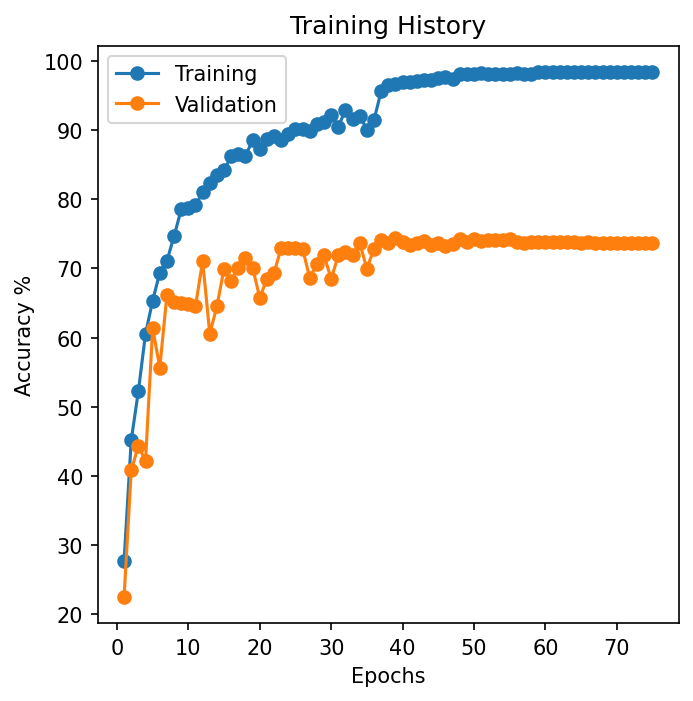

In [22]:
figure = plt.figure(figsize=(5, 5),dpi=150)
plt.plot(range(1,trainHistory.size(0)+1), trainHistory[:,[1,4]]*100.0,"o-")
plt.legend(["Training","Validation"])
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.show()

# Test Accuracy

In [23]:
trainedModel.eval()
testLoss = 0
testTruePositives = 0
testN=0
predicted=[]
actual=[]
for inputs, targets in testDataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.set_grad_enabled(False):
        modelOutputs = model(inputs)
        predictedClass = torch.max(modelOutputs, 1)[1]
        loss = torch.nn.CrossEntropyLoss()(modelOutputs, torch.max(targets,1)[1])               
    testLoss += loss.item() * len(targets)
    testN += len(targets)
    predicted+=predictedClass.tolist()
    actual+=torch.max(targets,1)[1].tolist()
    testTruePositives += torch.sum(predictedClass == torch.max(targets,1)[1])  

testLoss /= testN
testAccuracy = testTruePositives.double() / testN

print(f'Test Data | Loss: {testLoss:10.4f} Accuracy: {testAccuracy*100:10.4f}%')

Test Data | Loss:     0.5294 Accuracy:    83.6927%


# Test Confusion Matrix

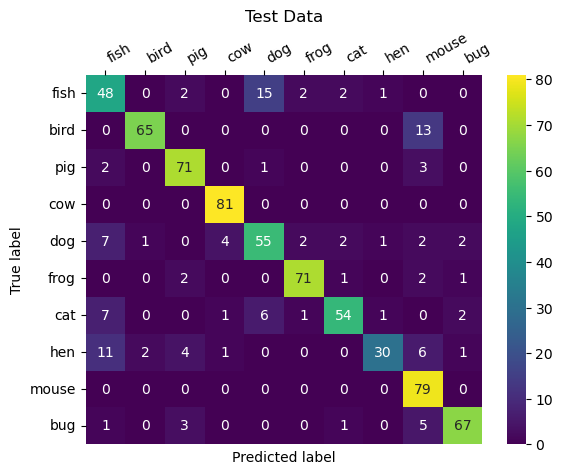

In [24]:
CM=confusion_matrix(actual, predicted)
class_names=[k for k in target_id_map.keys()]
df_cm = pd.DataFrame(CM, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='left')
heatmap.xaxis.tick_top()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Test Data")
plt.show()